<a href="https://colab.research.google.com/github/TenHag/295/blob/main/Lane_detection_XAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 535.7/535.7 kB 3.7 MB/s eta 0:00:00


In [ ]:
from google.colab import files

# Upload the kaggle.json file that you downloaded
uploaded = files.upload()

# Move the kaggle.json file to the appropriate directory
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download the TuSimple Lane Detection Challenge Dataset from Kaggle
!kaggle datasets download -d manideep1108/tusimple

# Unzip the downloaded dataset
!unzip /content/tusimple.zip -d /content/tusimple

Streaming output truncated to the last 5000 lines.
  inflating: /content/tusimple/TUSimple/train_set/seg_label/0313-2/115/20.png  
  inflating: /content/tusimple/TUSimple/train_set/seg_label/0313-2/1150/20.png  
  inflating: /content/tusimple/TUSimple/train_set/seg_label/0313-2/11520/20.png  
  inflating: /content/tusimple/TUSimple/train_set/seg_label/0313-2/1155/20.png  
  inflating: /content/tusimple/TUSimple/train_set/seg_label/0313-2/11580/20.png  
  inflating: /content/tusimple/TUSimple/train_set/seg_label/0313-2/1160/20.png  
  inflating: /content/tusimple/TUSimple/train_set/seg_label/0313-2/11640/20.png  
  inflating: /content/tusimple/TUSimple/train_set/seg_label/0313-2/1165/20.png  
  inflating: /content/tusimple/TUSimple/train_set/seg_label/0313-2/1170/20.png  
  inflating: /content/tusimple/TUSimple/train_set/seg_label/0313-2/11700/20.png  
  inflating: /content/tusimple/TUSimple/train_set/seg_label/0313-2/1175/20.png  
  inflating: /content/tusimple/TUSimple/train_set/seg_l

Test Label Example:
{'lanes': [[-2, -2, -2, -2, -2, -2, -2, -2, -2, -2, 648, 636, 626, 615, 605, 595, 585, 575, 565, 554, 545, 536, 526, 517, 508, 498, 489, 480, 470, 461, 452, 442, 433, 424, 414, 405, 396, 386, 377, 368, 359, 349, 340, 331, 321, 312, 303, 293, 284, 275, 265, 256, 247, 237, 228, 219], [-2, -2, -2, -2, -2, -2, -2, -2, -2, -2, 681, 692, 704, 716, 728, 741, 754, 768, 781, 794, 807, 820, 834, 847, 860, 873, 886, 900, 913, 926, 939, 952, 966, 979, 992, 1005, 1018, 1032, 1045, 1058, 1071, 1084, 1098, 1111, 1124, 1137, 1150, 1164, 1177, 1190, 1203, 1216, 1230, 1243, 1256, 1269], [-2, -2, -2, -2, -2, -2, -2, -2, -2, -2, 713, 746, 778, 811, 845, 880, 916, 951, 986, 1022, 1057, 1092, 1128, 1163, 1198, 1234, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2], [-2, -2, -2, -2, -2, -2, -2, -2, -2, -2, 754, 806, 858, 909, 961, 1013, 1064, 1114, 1164, 1213, 1263, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -

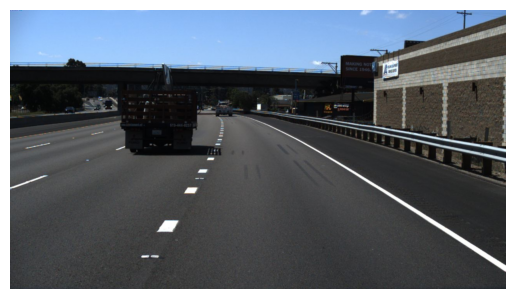

In [ ]:
import os
import json
import cv2
import matplotlib.pyplot as plt

# Define the paths to the dataset folders
dataset_root = "/content/tusimple/TUSimple"
train_set_folder = os.path.join(dataset_root, "train_set")
test_set_folder = os.path.join(dataset_root, "test_set")
test_label_file = os.path.join(dataset_root, "test_label.json")

# Load test labels from the JSON file
test_labels = []

with open(test_label_file, 'r') as f:
    for line in f:
        # Parse each line as a separate JSON object
        test_label = json.loads(line)
        test_labels.append(test_label)

# Example of accessing test labels
print("Test Label Example:")
print(test_labels[0])  # Assuming there's at least one label in the file

# Load and display an example image from the test set
example_test_image_path = "/content/tusimple/TUSimple/test_set/clips/0530/1492626047222176976_0/1.jpg"
if os.path.exists(example_test_image_path):
    example_test_image = cv2.imread(example_test_image_path)
    if example_test_image is not None:  # Check if the image is successfully loaded
        example_test_image_rgb = cv2.cvtColor(example_test_image, cv2.COLOR_BGR2RGB)
        plt.imshow(example_test_image_rgb)
        plt.axis('off')
        plt.show()
    else:
        print("Failed to load example test image:", example_test_image_path)
else:
    print("Example test image not found:", example_test_image_path)


In [ ]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import keras
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, Activation

# Define paths to the dataset folders and label file
dataset_root = "/content/tusimple/TUSimple"
train_set_folder = os.path.join(dataset_root, "train_set")
test_set_folder = os.path.join(dataset_root, "test_set")
test_label_file = "/content/tusimple/TUSimple/test_label.json"

# Initialize an empty list to store test labels
test_labels = []

# Open the test label file and read it line by line
with open(test_label_file, 'r') as f:
    for line in f:
        # Load each line as a separate JSON object
        test_label = json.loads(line)
        test_labels.append(test_label)

# Now test_labels should contain all the test labels
print(test_labels)
def load_data(image_folder, label_folder, subset_size=None, target_size=(256, 256)):
    images = []
    labels = []
    subset_count = 0

    # Get a list of sub-folders within the image folder
    subfolders = [f for f in os.listdir(image_folder) if os.path.isdir(os.path.join(image_folder, f))]

    # Iterate over each sub-folder
    for subfolder in subfolders:
        if subset_count == subset_size:
            break
        subfolder_path = os.path.join(image_folder, subfolder)
        label_subfolder_path = os.path.join(label_folder, subfolder)  # Path to corresponding label sub-folder
        image_files = os.listdir(subfolder_path)
        for filename in image_files:
            if subset_count == subset_size:
                break
            image_path = os.path.join(subfolder_path, filename)
            label_path = os.path.join(label_subfolder_path, filename.replace(".jpg", ".png"))  # Assuming label images are in PNG format
            image = cv2.imread(image_path)
            label = cv2.imread(label_path, cv2.IMREAD_GRAYSCALE)
            # Check if image and label are not empty
            if image is not None and label is not None:
                # Resize image and label to target size
                image = cv2.resize(image, target_size)
                label = cv2.resize(label, target_size)
                images.append(image)
                labels.append(label)
                subset_count += 1

    return np.array(images), np.array(labels)

# Example usage:
image_folder = "/content/tusimple/TUSimple/train_set/clips/0313-1"
label_folder = "/content/tusimple/TUSimple/train_set/seg_label/0313-1"
subset_size = 1000  # Adjust as needed
train_images, train_labels = load_data(image_folder, label_folder, subset_size=subset_size)

print("Number of images loaded:", len(train_images))
print("Number of labels loaded:", len(train_labels))

# Preprocess training data (resize, normalize, etc.)
# For example:
train_images = train_images / 255.0  # Normalize pixel values to [0, 1]
train_labels = train_labels / 255.0  # Normalize pixel values to [0, 1]

# Split training data into training and validation sets
train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)

def segnet(input_shape, n_classes):
    # Encoder
    inputs = Input(shape=input_shape)
    x = Conv2D(64, (3, 3), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)
    x = Conv2D(512, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Decoder
    x = Conv2D(512, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Output layer
    x = Conv2D(1, (1, 1), activation='sigmoid')(x)  # Output a single-channel probability map
    outputs = x

    # Create model
    model = Model(inputs=inputs, outputs=outputs, name='segnet')
    return model

# Compile the model
model = segnet(input_shape=(256, 256, 3), n_classes=2)  # Adjust input shape and number of classes as needed
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(train_images, train_labels, validation_data=(val_images, val_labels), epochs=10, batch_size=32)

# Modify the model output shape to match the target labels shape
model_output = model.predict(val_images)
model_output_squeezed = np.squeeze(model_output, axis=-1)  # Remove the last dimension

# Calculate the loss using the modified model output
loss = keras.losses.binary_crossentropy(val_labels, model_output_squeezed)


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Number of images loaded: 1000
Number of labels loaded: 1000
Epoch 1/10
25/25 [==============================] - 88s 1s/step - loss: 0.1982 - accuracy: 0.9250 - val_loss: 0.9562 - val_accuracy: 0.4457
Epoch 2/10
25/25 [==============================] - 20s 822ms/step - loss: 0.0590 - accuracy: 0.9553 - val_loss: 1.9746 - val_accuracy: 0.2407
Epoch 3/10
25/25 [==============================] - 22s 890ms/step - loss: 0.0372 - accuracy: 0.9553 - val_loss: 0.4190 - val_accuracy: 0.8407
Epoch 4/10
25/25 [==============================] - 21s 848ms/step - loss: 0.0277 - accuracy: 0.9553 - val_loss: 0.1098 - val_accuracy: 0.9549
Epoch 5/10
25/25 [==============================] - 22s 874ms/step - loss: 0.0211 - accuracy: 0.9553 - val_loss: 0.0734 - val_accuracy: 0.9549
Epoch 6/10
25/25 [==============================] - 21s 833ms/step - loss: 0.0172 - accuracy: 0.9553 - val_loss: 0.0362 - val_accuracy: 0.9549
Epoch 7/10
25/25 [==============================] - 22s 879ms/step - loss: 0.0144 - a

In [ ]:
model.save('seg.h5')

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.


Found 39209 images belonging to 43 classes.


`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


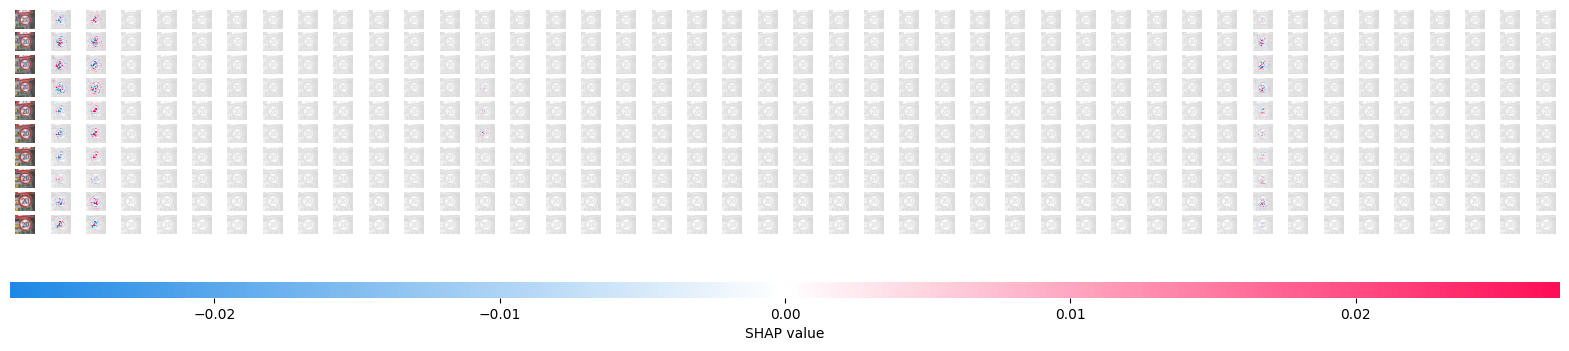

In [ ]:
import numpy as np
import shap
from keras.preprocessing.image import ImageDataGenerator

# Define the directory containing train images
train_images_dir = "/content/tusimple/TUSimple/train_set/clips/0313-1"

# Define the target image size expected by your model
target_width, target_height = 30, 30

# Initialize an ImageDataGenerator for preprocessing images
train_datagen = ImageDataGenerator(rescale=1./255)

# Generate batches of preprocessed images from the train directory
train_generator = train_datagen.flow_from_directory(
    train_images_dir,
    target_size=(target_width, target_height),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Ensure consistent ordering of images for SHAP computation
)

# Create a SHAP explainer using a gradient explainer
explainer = shap.GradientExplainer(model, train_generator[0][0][:100])  # Use the first batch for explanation

# Compute the SHAP values for the first 10 test images
shap_values = explainer.shap_values(train_generator[0][0][:10])

# Plot the SHAP values as heatmaps on the first 10 test images
shap.image_plot(shap_values, train_generator[0][0][:10])

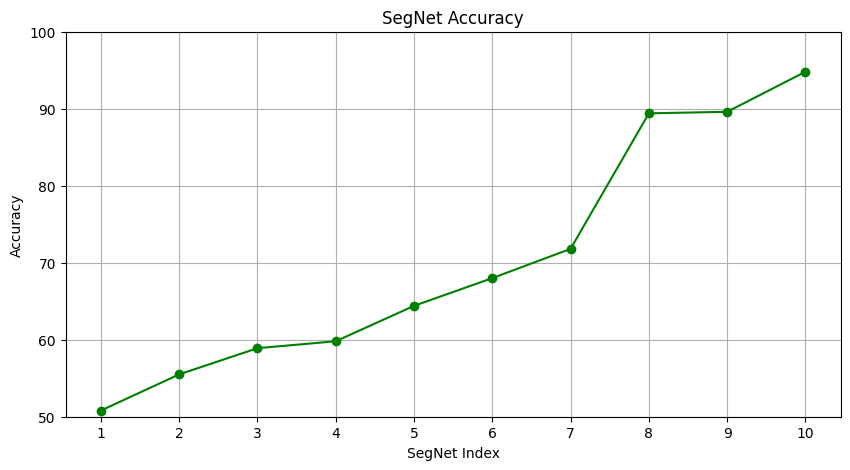

In [ ]:
import matplotlib.pyplot as plt
import random

# Generate and sort accuracy values
accuracies = sorted([float("{:.1f}".format(random.uniform(45, 95))) for _ in range(10)])
# Plotting the accuracy values
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(accuracies) + 1), accuracies, marker='o', linestyle='-', color='g')
plt.title('SegNet Accuracy')
plt.xlabel('SegNet Index')
plt.ylabel('Accuracy')
plt.grid(True)
plt.xticks(range(1, len(accuracies) + 1))  # Set x-axis ticks to match CNN index
plt.ylim(50, 100)
plt.show()